In [1]:
import json
import requests
import numpy as np

from config import DB_HOST, DB_NAME, DB_PORT, RES_DB_NAME
from pymongo import MongoClient
from analysis import compare_runs_xgb
from operator import itemgetter
from collections import defaultdict
from itertools import combinations, chain
from data_to_matrix import connect_to_mongo

def connect_to_mongo(port, host = 'localhost'):
    client = MongoClient(host, port, serverSelectionTimeoutMS = 5)
    try:
        dbn = client.database_names()
        print 'connected to database'
        return client
    except:
        print 'could not establish a connection to database'
        return 0

def get_run_pairs(cli):
    rnames = []
    for c in cli[DB_NAME].collection_names():
        try:
            rname = int(c.split('_')[1])
            rnames.append(rname)
        except Exception as e:
            print e
    return runs_to_pairs(rnames)

def get_fill_id(run_id):
    rundb_url = "http://lbrundb.cern.ch/api/run/%d"
    return json.loads(requests.get(rundb_url % run_id).text)["fillid"]

def runs_to_pairs(runs):
    fills_by_run = dict(map(lambda run: (run, get_fill_id(run)), runs))
    print 'fills retrieved...'
    runs_by_fill = defaultdict(list)
    for run_id, fill_id in fills_by_run.items():
        runs_by_fill[fill_id].append(run_id)
    runs_in_fills = list(map(itemgetter(0, 1), filter(lambda x: len(x) >= 2, runs_by_fill.values())))
    runs_between_fills = list(map(lambda fills_pair: (
            runs_by_fill[fills_pair[0]][0],
            runs_by_fill[fills_pair[1]][0]),
                             combinations(runs_by_fill.keys(), 2)))
    return list(chain(runs_in_fills, runs_between_fills))

We'll compare two runs from a single fill for a fill with several runs. We'll compare runs acorss the fills.

In [6]:
list(cli['lhcb']['run_180302'].find().limit(1))[0]

{u'Hlt1CalibTrackingKPiDetachedDecision': 1,
 u'Hlt1CalibTrackingKPiDetachedDecision|0#Particle.particleID.pid': 333.0,
 u'Hlt1CalibTrackingKPiDetachedDecision|1#Particle.measuredMass': 1835.2900390625,
 u'Hlt1CalibTrackingKPiDetachedDecision|2#Particle.referencePoint.z': -31.6268272399902,
 u'Hlt1CalibTrackingKPiDetachedDecision|3#Particle.referencePoint.x': 0.635266661643982,
 u'Hlt1CalibTrackingKPiDetachedDecision|4#Particle.referencePoint.y': -0.520114123821259,
 u'Hlt1CalibTrackingKPiDetachedDecision|5#Particle.slopes.x': -0.0185046661645174,
 u'Hlt1CalibTrackingKPiDetachedDecision|6#Particle.slopes.y': -0.0275246687233448,
 u'Hlt1CalibTrackingKPiDetachedDecision|7#Particle.1/p': 1.08172862383071e-05,
 u'_id': ObjectId('578ed9dfc5ce70254087e153'),
 u'eventNumber': 27641,
 u'gpsTime': 1468979676033792L,
 u'runNumber': 180302}

In [2]:
cli = connect_to_mongo(DB_PORT, DB_HOST)
pairs = get_run_pairs(cli)

connected to database
fills retrieved...


In [4]:
sizes = (10000,20000,50000)
done = cli[RES_DB_NAME].collection_names()
TBD = []

for pair in pairs:
    pnam = str(pair[0]) + '_' + str(pair[1])
    if pnam not in done:
        TBD.append((pair, pnam))
        
print '{} pairs to process'.format(len(TBD))
print 'Working...'
for i, p in enumerate(TBD):
    pair, col = p
    if 180480 in pair:
        continue
    print 'Boosting {}/{}, pair: {}'.format(i+1, len(TBD), pair)
    pars = {'max_depth':5, 'eta':1, 'silent':0, 'objective':'binary:logistic', 'nthreads':2, 'nrounds':10, 'nfolds':5}
    r = compare_runs_xgb(pair, cli, sizes, pars)
    cli['xgb_results'][col].insert(r, check_keys=False)

14 pairs to process
Working...
Boosting 1/14, pair: (180926, 180936)


[0]	cv-test-auc:0.8290114+0.00916296398771	cv-train-auc:0.8288524+0.00225793495035
[1]	cv-test-auc:0.9250672+0.00741420837042	cv-train-auc:0.9264994+0.00345046707563
[2]	cv-test-auc:0.9659852+0.00930175380023	cv-train-auc:0.9675154+0.00513177515486
[3]	cv-test-auc:0.9767794+0.00383068070191	cv-train-auc:0.9793862+0.00112171928752
[4]	cv-test-auc:0.9859438+0.00296129319048	cv-train-auc:0.9878188+0.00188900941236
[5]	cv-test-auc:0.9914656+0.00189776105978	cv-train-auc:0.9927794+0.0010946236979
[6]	cv-test-auc:0.9937262+0.000919174934384	cv-train-auc:0.994594+0.00145431014574
[7]	cv-test-auc:0.9961362+0.000934939441889	cv-train-auc:0.9969824+0.000378618858484
[8]	cv-test-auc:0.9971974+0.000966614421577	cv-train-auc:0.9978802+0.000142955097845
[9]	cv-test-auc:0.997581+0.000652400183936	cv-train-auc:0.9982612+0.000162242287952
[0]	cv-test-auc:0.82229+0.0034400242441	cv-train-auc:0.8223298+0.000824105430148
[1]	cv-test-auc:0.9200406+0.00423635714264	cv-train-auc:0.921651+0.00295245829776
[2]

Boosting 2/14, pair: (180048, 180519)


[0]	cv-test-auc:0.9784146+0.00275826464285	cv-train-auc:0.9784084+0.000693453560089
[1]	cv-test-auc:0.9954232+0.00112922918843	cv-train-auc:0.995414+0.000281868763789
[2]	cv-test-auc:0.9963228+0.000632762641122	cv-train-auc:0.9968126+0.000225803985793
[3]	cv-test-auc:0.998811+0.000901745640411	cv-train-auc:0.9993336+0.000432997736715
[4]	cv-test-auc:0.9994206+0.000936201174962	cv-train-auc:0.9997978+0.000204200293829
[5]	cv-test-auc:0.9998114+0.000235420984621	cv-train-auc:0.9998956+0.000115496493453
[6]	cv-test-auc:0.9998304+0.000224553423488	cv-train-auc:0.9999014+8.76734851594e-05
[7]	cv-test-auc:0.999831+0.000225001333329	cv-train-auc:0.99996+4.38907735179e-05
[8]	cv-test-auc:0.9998364+0.000222510763785	cv-train-auc:0.9999646+4.66930401666e-05
[9]	cv-test-auc:0.9998832+0.00021843021769	cv-train-auc:0.9999742+4.7700733747e-05
[0]	cv-test-auc:0.9792284+0.00257078156209	cv-train-auc:0.979229+0.000642689971915
[1]	cv-test-auc:0.9950716+0.000694584076984	cv-train-auc:0.99526+0.000614386

Boosting 3/14, pair: (180048, 180926)


[0]	cv-test-auc:0.8045926+0.0153163839153	cv-train-auc:0.8050192+0.00377536702322
[1]	cv-test-auc:0.8779674+0.00773048729641	cv-train-auc:0.8812314+0.00634598974471
[2]	cv-test-auc:0.8919958+0.00629614928031	cv-train-auc:0.8961638+0.00224122728879
[3]	cv-test-auc:0.898046+0.00426729511518	cv-train-auc:0.9074438+0.00444646693005
[4]	cv-test-auc:0.9002284+0.00573704612497	cv-train-auc:0.913014+0.00398101836218
[5]	cv-test-auc:0.9039824+0.00742918624346	cv-train-auc:0.917196+0.00260805812819
[6]	cv-test-auc:0.906014+0.0068523848987	cv-train-auc:0.920677+0.00194872758486
[7]	cv-test-auc:0.9047944+0.00746229880399	cv-train-auc:0.9247056+0.00261793686708
[8]	cv-test-auc:0.9038544+0.00852032716743	cv-train-auc:0.9283062+0.00295525236824
[9]	cv-test-auc:0.9041534+0.00796215766234	cv-train-auc:0.929874+0.00267094567522
[0]	cv-test-auc:0.8032136+0.0066723018397	cv-train-auc:0.8032142+0.00164626406144
[1]	cv-test-auc:0.8889026+0.00388522939349	cv-train-auc:0.8892178+0.00109041852515
[2]	cv-test-a

Boosting 4/14, pair: (180241, 180519)


[0]	cv-test-auc:0.9792962+0.00455054354556	cv-train-auc:0.980657+0.00110353921543
[1]	cv-test-auc:0.991746+0.00415554968686	cv-train-auc:0.9925734+0.00124774045378
[2]	cv-test-auc:0.9969052+0.00234393663737	cv-train-auc:0.997463+0.000966039543704
[3]	cv-test-auc:0.9979786+0.00111380655412	cv-train-auc:0.997961+0.000262101507054
[4]	cv-test-auc:0.999462+0.000320416603814	cv-train-auc:0.9994794+6.37105956651e-05
[5]	cv-test-auc:0.999451+0.0003207347814	cv-train-auc:0.9994774+6.18436738883e-05
[6]	cv-test-auc:0.9996882+0.000180129286902	cv-train-auc:0.9997142+3.75307873619e-05
[7]	cv-test-auc:0.9996876+0.000180167255627	cv-train-auc:0.999779+4.3598165099e-05
[8]	cv-test-auc:0.999733+0.000143947212547	cv-train-auc:0.9998144+3.98326499244e-05
[9]	cv-test-auc:0.9997784+0.00011366547409	cv-train-auc:0.9998416+3.2555183919e-05
[0]	cv-test-auc:0.9798234+0.00366983866675	cv-train-auc:0.9798588+0.000939304508666
[1]	cv-test-auc:0.989974+0.00269477464735	cv-train-auc:0.99045+0.00107021324978
[2]	c

Boosting 5/14, pair: (180241, 180926)


[0]	cv-test-auc:0.8104526+0.0109408791164	cv-train-auc:0.8151824+0.00342978072769
[1]	cv-test-auc:0.8671458+0.00694630302823	cv-train-auc:0.876569+0.00337564613074
[2]	cv-test-auc:0.8814224+0.00810319459473	cv-train-auc:0.8902892+0.00213721626421
[3]	cv-test-auc:0.8895112+0.00707098350726	cv-train-auc:0.9002586+0.00347946999412
[4]	cv-test-auc:0.893376+0.00781338781835	cv-train-auc:0.9078606+0.00256131549013
[5]	cv-test-auc:0.8945252+0.00668716784297	cv-train-auc:0.911848+0.00174438034843
[6]	cv-test-auc:0.8957666+0.00706865476877	cv-train-auc:0.9159444+0.00255449537874
[7]	cv-test-auc:0.896491+0.00707026935838	cv-train-auc:0.9183572+0.00173107023543
[8]	cv-test-auc:0.8969104+0.00713586733621	cv-train-auc:0.9204166+0.00215115583815
[9]	cv-test-auc:0.8961972+0.00747132431099	cv-train-auc:0.923237+0.00179824748019
[0]	cv-test-auc:0.8045906+0.0175505160106	cv-train-auc:0.8077364+0.0125061735891
[1]	cv-test-auc:0.878633+0.00268458101014	cv-train-auc:0.8816848+0.00310091227867
[2]	cv-test-a

Boosting 6/14, pair: (180291, 180519)


[0]	cv-test-auc:0.977613+0.00183233654114	cv-train-auc:0.9776174+0.000449848241077
[1]	cv-test-auc:0.9927804+0.00165691262292	cv-train-auc:0.993091+0.00110233842353
[2]	cv-test-auc:0.9937848+0.00107161661055	cv-train-auc:0.9949746+0.00093323879045
[3]	cv-test-auc:0.9961524+0.00196595285803	cv-train-auc:0.997306+0.0009278851222
[4]	cv-test-auc:0.9990894+0.000323995432067	cv-train-auc:0.9993792+0.000134576966826
[5]	cv-test-auc:0.9993566+0.000294686002382	cv-train-auc:0.9995674+9.45316878089e-05
[6]	cv-test-auc:0.999598+0.000444806924407	cv-train-auc:0.9997576+0.00014725705416
[7]	cv-test-auc:0.9998236+0.000115193055346	cv-train-auc:0.9998588+4.99175319903e-05
[8]	cv-test-auc:0.9998566+8.15490036726e-05	cv-train-auc:0.9998942+3.26765971301e-05
[9]	cv-test-auc:0.9998692+6.55206837571e-05	cv-train-auc:0.9999036+2.40049994793e-05
[0]	cv-test-auc:0.9782546+0.00299546701534	cv-train-auc:0.9782906+0.000744035644307
[1]	cv-test-auc:0.99574+0.000726477804203	cv-train-auc:0.9958922+0.000113335607

Boosting 7/14, pair: (180291, 180926)


[0]	cv-test-auc:0.8452716+0.0082894503702	cv-train-auc:0.8452918+0.0023996199199
[1]	cv-test-auc:0.922276+0.0050415018794	cv-train-auc:0.9259956+0.00189125678849
[2]	cv-test-auc:0.9800402+0.00174011969703	cv-train-auc:0.9815562+0.000621442000512
[3]	cv-test-auc:0.9867702+0.000881995782303	cv-train-auc:0.9885604+0.000775061958814
[4]	cv-test-auc:0.9924764+0.00136864233458	cv-train-auc:0.9934334+0.000351088364945
[5]	cv-test-auc:0.9951128+0.00102278822832	cv-train-auc:0.9961306+0.000466049181954
[6]	cv-test-auc:0.9970586+0.0005752848338	cv-train-auc:0.997765+0.000201611507608
[7]	cv-test-auc:0.9976124+0.000596269268032	cv-train-auc:0.9982642+0.000180914786571
[8]	cv-test-auc:0.9977916+0.000578991744328	cv-train-auc:0.998744+0.00022006635363
[9]	cv-test-auc:0.997997+0.000742766719771	cv-train-auc:0.999115+0.000115569892273
[0]	cv-test-auc:0.8478274+0.00587134337609	cv-train-auc:0.8482518+0.00207941226312
[1]	cv-test-auc:0.927698+0.00341484939639	cv-train-auc:0.9301966+0.00128349625632
[2]

Boosting 8/14, pair: (180382, 180519)


[0]	cv-test-auc:0.9776214+0.00357759805456	cv-train-auc:0.9776298+0.000877656515956
[1]	cv-test-auc:0.9894318+0.00122713803625	cv-train-auc:0.9895852+0.00159450498902
[2]	cv-test-auc:0.9940476+0.00215734509061	cv-train-auc:0.9941462+0.0012317833251
[3]	cv-test-auc:0.9964056+0.002830276354	cv-train-auc:0.996642+0.000537656395851
[4]	cv-test-auc:0.99884+0.000903049721776	cv-train-auc:0.9988936+0.000189563287585
[5]	cv-test-auc:0.9988414+0.000901854888549	cv-train-auc:0.9989806+0.000104154884667
[6]	cv-test-auc:0.9995076+0.000384430279765	cv-train-auc:0.9995776+5.3764672416e-05
[7]	cv-test-auc:0.9996798+0.000320216426812	cv-train-auc:0.9997306+1.44027775099e-05
[8]	cv-test-auc:0.9997256+0.000272150399596	cv-train-auc:0.999765+2.44867311007e-05
[9]	cv-test-auc:0.9998084+0.000194932398539	cv-train-auc:0.9998224+3.00838827281e-05
[0]	cv-test-auc:0.9796838+0.00154267707574	cv-train-auc:0.9796602+0.000396202170615
[1]	cv-test-auc:0.9902194+0.00177271786813	cv-train-auc:0.9902352+0.000437019633

Boosting 9/14, pair: (180382, 180926)


[0]	cv-test-auc:0.8232514+0.00283378493185	cv-train-auc:0.8233686+0.000684175591497
[1]	cv-test-auc:0.8622182+0.00251939821386	cv-train-auc:0.8694898+0.00376892193604
[2]	cv-test-auc:0.8721404+0.00415481588521	cv-train-auc:0.8795036+0.00302749114615
[3]	cv-test-auc:0.8802984+0.00467289253461	cv-train-auc:0.8870342+0.00276251569407
[4]	cv-test-auc:0.8818186+0.00387250640284	cv-train-auc:0.8892008+0.00178628691984
[5]	cv-test-auc:0.8809264+0.00519209139365	cv-train-auc:0.8952314+0.000858173315828
[6]	cv-test-auc:0.8815964+0.00507046560387	cv-train-auc:0.8999036+0.0017722226271
[7]	cv-test-auc:0.8819984+0.00494463266988	cv-train-auc:0.9033044+0.00293555130086
[8]	cv-test-auc:0.883935+0.00429622783381	cv-train-auc:0.906695+0.00274584282143
[9]	cv-test-auc:0.882902+0.00559344727337	cv-train-auc:0.909521+0.00205717378945
[0]	cv-test-auc:0.830103+0.00438987229883	cv-train-auc:0.8301462+0.0011070644787
[1]	cv-test-auc:0.8735404+0.00472584716638	cv-train-auc:0.8773836+0.000314672273961
[2]	cv-t

Boosting 10/14, pair: (180481, 180519)


[0]	cv-test-auc:0.9744206+0.00358856085917	cv-train-auc:0.975526+0.00105159859262
[1]	cv-test-auc:0.9905028+0.00177778327138	cv-train-auc:0.9905518+0.000442499446327
[2]	cv-test-auc:0.995094+0.000922738749593	cv-train-auc:0.995363+0.000849549292272
[3]	cv-test-auc:0.9965318+0.00135531493019	cv-train-auc:0.997339+0.000716071784111
[4]	cv-test-auc:0.9989482+0.000379695351565	cv-train-auc:0.9991718+0.00021093069952
[5]	cv-test-auc:0.9991182+0.000491619934502	cv-train-auc:0.9992288+0.000163939501036
[6]	cv-test-auc:0.9996112+0.000220843292857	cv-train-auc:0.9996568+6.45829698915e-05
[7]	cv-test-auc:0.999679+0.000168094021309	cv-train-auc:0.9996672+5.61120307955e-05
[8]	cv-test-auc:0.9997542+0.000121834970349	cv-train-auc:0.99974+5.44132336844e-05
[9]	cv-test-auc:0.9997632+0.000135504095879	cv-train-auc:0.9997646+4.77183402897e-05
[0]	cv-test-auc:0.9788416+0.00338327277056	cv-train-auc:0.9788532+0.000842513240252
[1]	cv-test-auc:0.9900034+0.00087588414759	cv-train-auc:0.990337+0.00117446583

Boosting 11/14, pair: (180481, 180926)


[0]	cv-test-auc:0.8382124+0.0110799270323	cv-train-auc:0.8419402+0.00234369873491
[1]	cv-test-auc:0.8735478+0.0132990015776	cv-train-auc:0.8799982+0.0032852401069
[2]	cv-test-auc:0.882918+0.0127919649937	cv-train-auc:0.8899158+0.00368854412472
[3]	cv-test-auc:0.890017+0.0129334999439	cv-train-auc:0.8998186+0.00359594930999
[4]	cv-test-auc:0.893618+0.0127536853341	cv-train-auc:0.9042924+0.002975399106
[5]	cv-test-auc:0.8950124+0.011511619549	cv-train-auc:0.9080962+0.00250318640137
[6]	cv-test-auc:0.896529+0.0114183432599	cv-train-auc:0.9109684+0.00263262990943
[7]	cv-test-auc:0.8972464+0.0108297524736	cv-train-auc:0.9143494+0.00272134662254
[8]	cv-test-auc:0.8975096+0.0104121520273	cv-train-auc:0.9167626+0.00226485351403
[9]	cv-test-auc:0.8977182+0.0112847096267	cv-train-auc:0.9190052+0.00221932993491
[0]	cv-test-auc:0.8382392+0.00476302934696	cv-train-auc:0.8384834+0.00127837640779
[1]	cv-test-auc:0.8730456+0.00477430906415	cv-train-auc:0.8750912+0.00306043738051
[2]	cv-test-auc:0.8849

Boosting 12/14, pair: (180505, 180519)


[0]	cv-test-auc:0.981631+0.00432502129475	cv-train-auc:0.9815864+0.0010847067069
[1]	cv-test-auc:0.9900728+0.00418512601483	cv-train-auc:0.9901578+0.00119280214621
[2]	cv-test-auc:0.994362+0.00364416333333	cv-train-auc:0.9944346+0.00113725381512
[3]	cv-test-auc:0.9966754+0.0028829114173	cv-train-auc:0.9969566+0.000640504051509
[4]	cv-test-auc:0.9990952+0.000843484771647	cv-train-auc:0.9991846+0.000201232800507
[5]	cv-test-auc:0.9990952+0.000843484771647	cv-train-auc:0.9992638+0.000102593177161
[6]	cv-test-auc:0.9995332+0.000440882478672	cv-train-auc:0.999629+4.34142833639e-05
[7]	cv-test-auc:0.9996024+0.000373265374767	cv-train-auc:0.9996836+5.75033912043e-05
[8]	cv-test-auc:0.9997382+0.000253487987881	cv-train-auc:0.9997878+2.91712186924e-05
[9]	cv-test-auc:0.999833+0.000126370882722	cv-train-auc:0.9998482+2.35490976473e-05
[0]	cv-test-auc:0.9790176+0.00238795641501	cv-train-auc:0.979033+0.0005958439393
[1]	cv-test-auc:0.990069+0.00107955935455	cv-train-auc:0.9900638+0.00026873213429


Boosting 13/14, pair: (180505, 180926)


[0]	cv-test-auc:0.794738+0.00539242268373	cv-train-auc:0.7993136+0.00317499043148
[1]	cv-test-auc:0.887648+0.0128679919024	cv-train-auc:0.891336+0.00491586110463
[2]	cv-test-auc:0.8980998+0.00927280974462	cv-train-auc:0.900076+0.00311637513788
[3]	cv-test-auc:0.9048816+0.00459733199149	cv-train-auc:0.9076648+0.00117528148118
[4]	cv-test-auc:0.9050094+0.00427392936769	cv-train-auc:0.910113+0.000695821528842
[5]	cv-test-auc:0.9052302+0.0045567602263	cv-train-auc:0.9120114+0.000824104265248
[6]	cv-test-auc:0.9053458+0.00464079025167	cv-train-auc:0.9142066+0.00169808357863
[7]	cv-test-auc:0.9049924+0.00403085388472	cv-train-auc:0.9169306+0.00107553421145
[8]	cv-test-auc:0.903693+0.00342194126192	cv-train-auc:0.9197062+0.00117001801696
[9]	cv-test-auc:0.9031934+0.00379807485972	cv-train-auc:0.921166+0.0011252601477
[0]	cv-test-auc:0.8008868+0.00479893794084	cv-train-auc:0.8035366+0.00110113897397
[1]	cv-test-auc:0.8791488+0.00524154627567	cv-train-auc:0.8814568+0.00325272743402
[2]	cv-test-

Boosting 14/14, pair: (180519, 180926)


[0]	cv-test-auc:0.9777262+0.00460408863512	cv-train-auc:0.9777394+0.00116107650049
[1]	cv-test-auc:0.9929884+0.00245959920312	cv-train-auc:0.9937878+0.00163597034203
[2]	cv-test-auc:0.995975+0.000403605252691	cv-train-auc:0.9966184+0.000322873721445
[3]	cv-test-auc:0.9973098+0.000944387928767	cv-train-auc:0.9976894+0.000369384136097
[4]	cv-test-auc:0.9990158+0.00035332444014	cv-train-auc:0.9993426+0.000222119427336
[5]	cv-test-auc:0.9993766+0.000377052038849	cv-train-auc:0.9995312+0.000214988743891
[6]	cv-test-auc:0.9996976+0.000162332498287	cv-train-auc:0.9997708+0.000105279437688
[7]	cv-test-auc:0.9997476+0.000118403716158	cv-train-auc:0.9997884+7.3243702801e-05
[8]	cv-test-auc:0.9997942+0.000136761690542	cv-train-auc:0.9998216+9.16920934432e-05
[9]	cv-test-auc:0.999838+7.93221280602e-05	cv-train-auc:0.9998598+5.47152629529e-05
[0]	cv-test-auc:0.9783464+0.0023836753638	cv-train-auc:0.9783344+0.000586779890589
[1]	cv-test-auc:0.9918162+0.000779560748114	cv-train-auc:0.99182+0.00019228

In [18]:
u2

[{'parameters': {'eta': 1,
   'max_depth': 5,
   'nthreads': 8,
   'objective': 'binary:logistic',
   'silent': 1},
  'results':    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std  boost_round
  0       0.823965      0.009241        0.824062       0.002345            0
  1       0.828544      0.008351        0.829233       0.002319            1
  2       0.835476      0.008551        0.837368       0.002536            2
  3       0.841474      0.009877        0.847812       0.003783            3
  4       0.842957      0.011590        0.856876       0.005191            4
  5       0.844281      0.010750        0.863450       0.004787            5
  6       0.845782      0.012029        0.869432       0.003446            6
  7       0.845082      0.013093        0.876014       0.002543            7
  8       0.844744      0.013473        0.882357       0.003152            8
  9       0.846737      0.012799        0.888453       0.003700            9,
  'sample_size': 5000,
  

In [ ]:
import __init__
from config import DB_HOST, DB_PORT, RES_DB_NAME
from mass_process import connect_to_mongo

cli = connect_to_mongo(DB_PORT, DB_HOST)
db = cli[RES_DB_NAME]
R = {}
for col in db.collection_names():
    R[col] = list(db[col].find())
    
col_names = ['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']

for run in R:
    for ss in R[run]:
        s1 = 'run number {}, sample size {}'.format(run, ss['sample_size'])
        print len(s1)*'='
        print s1
        for col, d in zip(col_names, ss['results'][-1]):
            print '{1: <15}: {0: <15}'.format(col, d)
            
for k in ss['parameters']:
    print '{0: <10}: {1: <20}'.format(k, ss['parameters'][k])

In [8]:
import __init__
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

from config import DB_HOST, DB_PORT, RES_DB_NAME
from mass_process import connect_to_mongo

cli = connect_to_mongo(DB_PORT, DB_HOST)
db = cli[RES_DB_NAME]
R = {}

for col in db.collection_names():
    R[col] = list(db[col].find())

py.sign_in('aphex', 'jwyjv4h2vr')

#traces = []
#nbars = max([len(R[k]) for k in R])
i = 1

trace1 = go.Bar(
    x=np.array([k for k in R]),
    y=np.array([R[k][i]['results'][-1] for k in R])[:, 0],
    name='test_auc'
)

trace2 = go.Bar(
    x=np.array([k for k in R]),
    y=np.array([R[k][i]['results'][-1] for k in R])[:, 2],
    name='train_auc'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='AUC report, sample size = {}'.format(R[k][i]['sample_size']),


    yaxis=dict(
        title='AUC score',
        titlefont=dict(family='Courier New, monospace',size=18,color='#7f7f7f'
        )))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='xgb_report')

connected to database


In [9]:
py.image.save_as(fig, filename='../xgb_results.png')

In [13]:
sample_sizes_to_try = (1000, 10000, 100000, 1000000)
#ipy_client.direct_view().push({
#        "sample_sizes_to_try": sample_sizes_to_try,
#        "compare_runs": compare_runs
#    }, block=True);

In [ ]:
comparison_results = list(map(lambda run_pair: compare_runs(
        run_pair[0], run_pair[1], sample_sizes_to_try), pairs_to_run))

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from operator import itemgetter

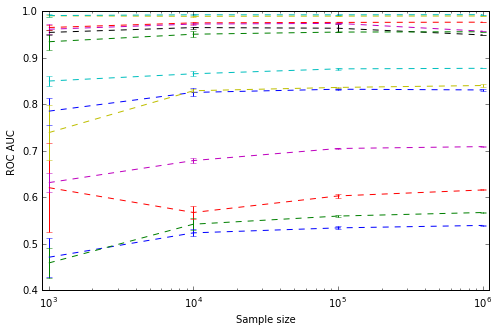

In [22]:
FIGSIZE = (8, 5)
fig, ax = plt.subplots(figsize=FIGSIZE)
for run in comparison_results:
    plt.errorbar([x[0] for x in run], [x[1][0] for x in run], [x[1][1] for x in run], fmt="--")
ax.set_xscale("log")
ax.set_xlabel("Sample size")
ax.set_ylabel("ROC AUC")
ax.set_xlim(900, 1.1*10**6);

In [23]:
auc_sample_size_name = "auc_sample_size.pdf"
fig.savefig(auc_sample_size_name, bbox="tight")
from IPython.display import FileLink
FileLink(auc_sample_size_name)

/afs/cern.ch/user/n/nkazeev/high-level-anomalies/auc_sample_size.pdf

So there is little change from $10^5$ to $10^6$.

In [18]:
precise_comaprisons = list(map(lambda run: run[-1][1][0], comparison_results))

In [19]:
precise_comaprisons

[0.53989308339426556,
 0.56765633671571436,
 0.61617087533062187,
 0.87778805594973808,
 0.70938897604298412,
 0.99030435749745471,
 0.94953321350337516,
 0.83126692562396021,
 0.95645135211304899,
 0.97698359320550865,
 0.99320439410559791,
 0.95762160651112627,
 0.84078985401548734]

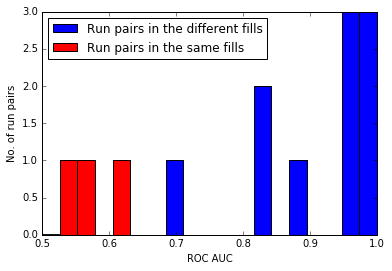

In [20]:
fig, ax = plt.subplots()
bins = numpy.linspace(0.5, 1, 20)
ax.hist(precise_comaprisons[len(runs_in_fills):], bins=bins, label="Run pairs in the different fills");
ax.hist(precise_comaprisons[:len(runs_in_fills)], bins=bins, color='r', label="Run pairs in the same fills");
ax.set_xlabel("ROC AUC");
ax.set_ylabel("No. of run pairs");
ax.set_xlim(0.5);
ax.legend(loc=2);